# Unit 4.4: Defining Efficient Data Loaders

In [80]:
import pandas as pd
import os
from git import Repo
from sklearn.model_selection import train_test_split
from collections import Counter
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import numpy as np

# Downloading the dataset

In [81]:
# if not os.path.exists("mnist-pngs"):
#     Repo.clone_from("https://github.com/rasbt/mnist-pngs", "data/mnist-pngs")

# CSV

In [82]:
df_train = pd.read_csv("data/mnist-pngs/train.csv")
df_test = pd.read_csv("data/mnist-pngs/test.csv")
df_train.head()

,filepath,label
0,train/0/16585.png,0
1,train/0/24537.png,0
2,train/0/25629.png,0
3,train/0/20751.png,0
4,train/0/34730.png,0


# Creating a validation split

In [83]:
train_df, val_df = train_test_split(df_train, test_size=0.1, random_state=42, stratify=df_train["label"])

train_df.to_csv("data/mnist-pngs/train_split.csv", index=False)
val_df.to_csv("data/mnist-pngs/val_split.csv", index=False)

In [84]:
print('Train split:', sorted(Counter(train_df["label"]).items()))
print('Validation split', sorted(Counter(val_df["label"]).items()))
print('Test set:', sorted(Counter(df_test["label"]).items()))


Train split: [(0, 5331), (1, 6068), (2, 5362), (3, 5518), (4, 5258), (5, 4879), (6, 5326), (7, 5638), (8, 5266), (9, 5354)]
Validation split [(0, 592), (1, 674), (2, 596), (3, 613), (4, 584), (5, 542), (6, 592), (7, 627), (8, 585), (9, 595)]
Test set: [(0, 980), (1, 1135), (2, 1032), (3, 1010), (4, 982), (5, 892), (6, 958), (7, 1028), (8, 974), (9, 1009)]


## 1) Defining the Dataset class

In [85]:
class MyDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform = None):
        df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform

        self.img_names = df['filepath']
        self.labels = df['label']
    
    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir, self.img_names[index]))

        if self.transform is not None:
            img = self.transform(img)
        
        label = self.labels[index]

        return img, label

    def __len__(self):
        return len(self.img_names)

## 2) Defining an optional batch visualization function

In [86]:
def viz_batch_images(batch):

    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Training images")
    plt.imshow(
        np.transpose(
            torchvision.utils.make_grid(batch[0][:64], padding=2, normalize=True), (1, 2, 0)
        )
    )
    plt.show()

## 3) Defining optional image transformations

In [87]:
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize(32),
            transforms.RandomCrop((28, 28)),
            transforms.ToTensor(),
            # normalize images to [-1, 1] range
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.Resize(32),
            transforms.CenterCrop((28, 28)),
            transforms.ToTensor(),
            # normalize images to [-1, 1] range
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
}

Here we resize 28 by 28 numbers to 32 by 32 images. This is not necessary, but it is a good practice to do so, because it gives us some randomness after we crop it back to 28 by 28. This is a common practice in image processing.

## 4) Defining the datasers and data loaders

In [88]:
train_dataset = MyDataset(
    csv_path="data/mnist-pngs/train_split.csv",
    img_dir="data/mnist-pngs/",
    transform=data_transforms["train"],
)

val_dataset = MyDataset(
    csv_path="data/mnist-pngs/val_split.csv",
    img_dir="data/mnist-pngs/",
    transform=data_transforms["test"],
)

test_dataset = MyDataset(
    csv_path="data/mnist-pngs/test.csv",
    img_dir="data/mnist-pngs/",
    transform=data_transforms["test"],
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=32,
    shuffle=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=False,
)

## 5) Testing the data loaders

 Batch index: 0 | Batch size: 32 | x shape: torch.Size([32, 1, 28, 28]) | y shape: torch.Size([32])
 Batch index: 1 | Batch size: 32 | x shape: torch.Size([32, 1, 28, 28]) | y shape: torch.Size([32])
 Batch index: 2 | Batch size: 32 | x shape: torch.Size([32, 1, 28, 28]) | y shape: torch.Size([32])
Labels from current batch: tensor([3, 4, 7, 0, 4, 7, 1, 5, 2, 3, 8, 8, 2, 9, 0, 0, 9, 3, 1, 6, 9, 8, 5, 2,
        4, 7, 3, 0, 1, 9, 0, 5])
Label tensor(2)


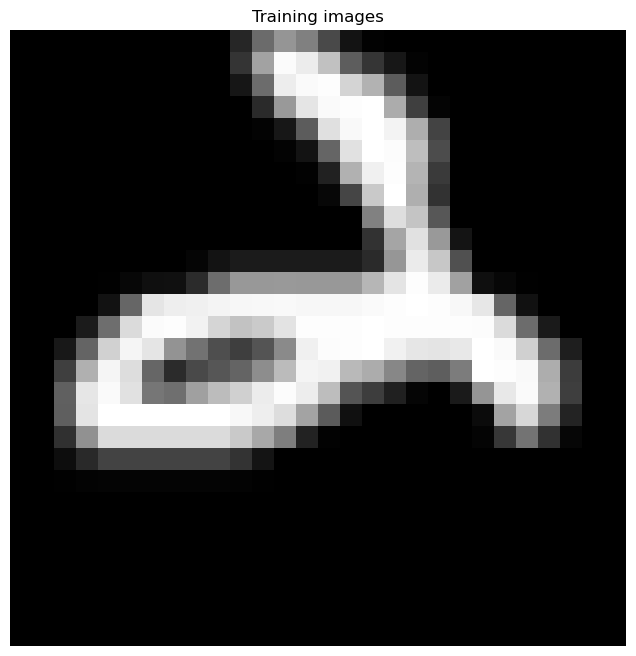

In [91]:
num_epochs = 1
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        if batch_idx >= 3:
            break
        print(" Batch index:", batch_idx, end="")
        print(" | Batch size:", y.shape[0], end="")
        print(" | x shape:", x.shape, end="")
        print(" | y shape:", y.shape)

print("Labels from current batch:", y)

# Uncomment to visualize a data batch:
batch = next(iter(train_loader))
print('Label', batch[1][0])
viz_batch_images(batch[0])